#### Importing all the necessary packages

In [1]:
# Importing all the packages necessary

import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
from captum.attr import IntegratedGradients, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap

#### Creating the directories

In [2]:
# Creating the directories

base_dir = 'dogscats/subset'
train_dir = os.path.join(base_dir, 'train')
train_cats_dir = os.path.join(base_dir, 'train', 'cats')
train_dogs_dir = os.path.join(base_dir, 'train', 'dogs')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

#### CNN Implementation with PyTorch

We implement the same CNN model with PyTorch. This is because Captum is designed specifically for PyTorch, leveraging its autograd functionality. The convolution, pooling, flattening, ReLU and sigmoid layers have been defined. The model below recreates the model implemented in the notebook, but in PyTorch.

In [3]:
# CNN Implementation in Pytorch which can be used with Captum for Integrated Gradients and GradCAM


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 9 * 9, 512)
        self.fc2 = nn.Linear(512, 1)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

model = ConvNet()

criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)

#### Defining the same image transformations as given in the course notebook

In [4]:
# Creating the datasets and dataloaders

train_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomRotation(40),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(150, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=validation_dir, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


#### Model Training

In [5]:
# Training the model using GPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ConvNet().to(device)

# Using BCE Losss
criterion = torch.nn.BCELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)

# Function to calculate accuracy
def calculate_accuracy(output, labels):
    predicted = (output > 0.5).float()  # Convert outputs to 0 or 1
    correct = (predicted == labels).float().sum()
    return correct / labels.size(0)

# Hyperparameters
num_epochs = 100
train_steps = 2000 // 32
val_steps = 1000 // 32

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    running_train_acc = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        if i >= train_steps:
            break
        inputs, labels = inputs.to(device), labels.float().to(device).unsqueeze(1)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        running_train_acc += calculate_accuracy(outputs, labels)

    # Calculate average loss and accuracy for training
    epoch_train_loss = running_train_loss / train_steps
    epoch_train_acc = running_train_acc / train_steps

    # Validation
    model.eval()
    running_val_loss = 0.0
    running_val_acc = 0.0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            if i >= val_steps:
                break
            inputs, labels = inputs.to(device), labels.float().to(device).unsqueeze(1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item()
            running_val_acc += calculate_accuracy(outputs, labels)

    # Calculate average loss and accuracy for validation
    epoch_val_loss = running_val_loss / val_steps
    epoch_val_acc = running_val_acc / val_steps

    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc.item())
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, '
          f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')


Epoch [1/100], Train Loss: 0.7037, Train Acc: 0.5030, Val Loss: 0.6891, Val Acc: 0.5786
Epoch [2/100], Train Loss: 0.6865, Train Acc: 0.5534, Val Loss: 0.6650, Val Acc: 0.6169
Epoch [3/100], Train Loss: 0.6668, Train Acc: 0.5983, Val Loss: 0.6408, Val Acc: 0.6260
Epoch [4/100], Train Loss: 0.6502, Train Acc: 0.6280, Val Loss: 0.6383, Val Acc: 0.6270
Epoch [5/100], Train Loss: 0.6457, Train Acc: 0.6255, Val Loss: 0.6185, Val Acc: 0.6704
Epoch [6/100], Train Loss: 0.6357, Train Acc: 0.6442, Val Loss: 0.6182, Val Acc: 0.6522
Epoch [7/100], Train Loss: 0.6177, Train Acc: 0.6724, Val Loss: 0.6005, Val Acc: 0.6794
Epoch [8/100], Train Loss: 0.6219, Train Acc: 0.6714, Val Loss: 0.5971, Val Acc: 0.6905
Epoch [9/100], Train Loss: 0.6101, Train Acc: 0.6784, Val Loss: 0.5783, Val Acc: 0.7077
Epoch [10/100], Train Loss: 0.5950, Train Acc: 0.6789, Val Loss: 0.5868, Val Acc: 0.6986
Epoch [11/100], Train Loss: 0.6013, Train Acc: 0.6870, Val Loss: 0.6448, Val Acc: 0.6300
Epoch [12/100], Train Loss: 0.

We have plotted the training and validation loss as well as accuracy, and its fairly similar to the one in the course notebook.

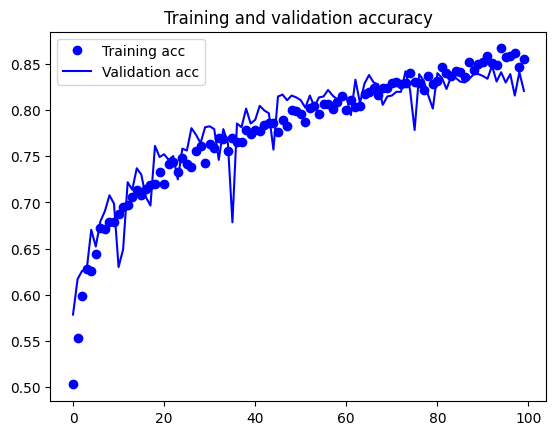

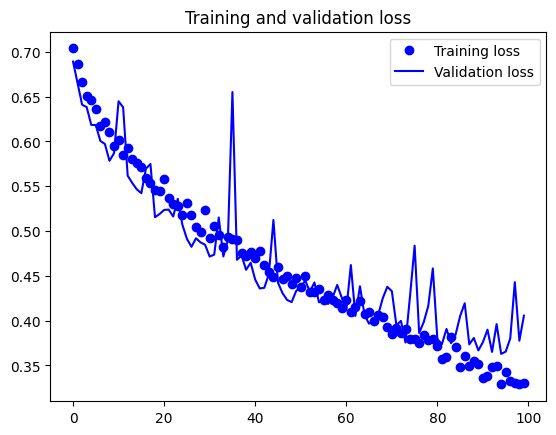

In [6]:
# Plotting the Accuracy and Loss

acc = history['train_acc']
val_acc = history['val_acc']
loss = history['train_loss']
val_loss = history['val_loss']

epochs = range(len(acc))

# Plot training and validation accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Plot training and validation loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [8]:
# Defining the test transform, same as the validation transform

test_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_dataset = datasets.ImageFolder(root=test_dir, transform=train_transforms)

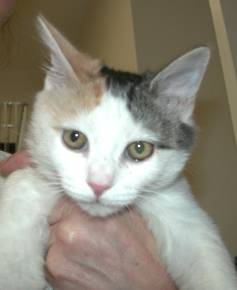

In [19]:
# Load a specific image from a folder

image_path = './dogscats/subset/test/cats/cat.1513.jpg'
# 1624, 1502, 1513, 1519, 1535
image = Image.open(image_path).convert('RGB')
image.show()
image_tensor = test_transforms(image).unsqueeze(0).to(device)

### Integrated Gradients

Integrated Gradients is a method that helps us understand how important each pixel is to the model's prediction by integrating gradients from a baseline to the input

### Integrated Gradients Equation

Let:
- **$f(x)$** be the output of the model (e.g., class probability).
- **$x$** be the input image.
- **$x^{\text{baseline}}$** be the baseline input (often a zeroed or black image).
- **$x' = \alpha x + (1 - \alpha) x^{\text{baseline}}$** for $\alpha$ in the range $[0, 1]$.

The Integrated Gradients for each input feature can be calculated using the following equation:

$$
\text{IG}(x) = (x - x^{\text{baseline}}) \cdot \int_{0}^{1} \nabla f(x') \, d\alpha
$$

Where:
- $\nabla f(x')$ is the gradient of the model output with respect to the input at the interpolated point $x'$.
- The dot product $(x - x^{\text{baseline}})$ scales the gradient by the difference between the input and the baseline.


#### Captum

We implement the Integrated Gradients method using Captum's `.attribute()` function. The parameters passed are:
1. image_tensor: The input tensor representing the image.
2. target: The class index.
3. n_steps: Number of interpolation steps to approximate the integral.










<Figure size 1200x400 with 0 Axes>

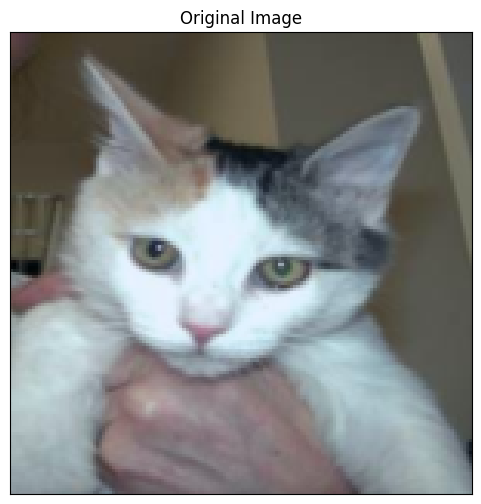

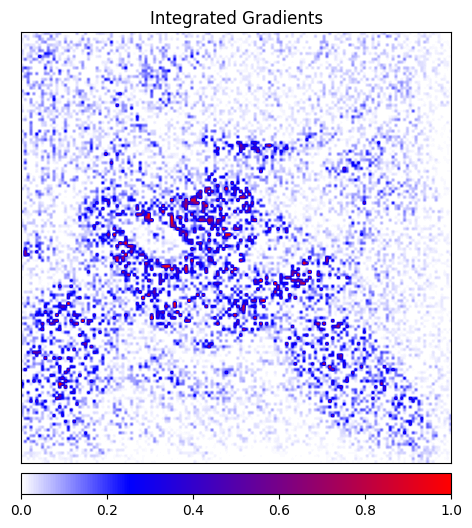

In [20]:
# Integrated Gradients Implementation
model.eval()

ig = IntegratedGradients(model)

default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#ff0000')],
                                                 N=256)

# Normalizes the image to 0-1 range
def normalize_image(img):
    img_min, img_max = img.min(), img.max()
    img = (img - img_min) / (img_max - img_min)
    return img

# Function to visualize attributions
def visualize_attributions(attributions, images):
    attr = attributions[0].cpu().detach().numpy().transpose(1, 2, 0)
    img = images[0].cpu().detach().numpy().transpose(1, 2, 0)

    img = normalize_image(img)
    plt.figure(figsize=(12, 4))

    viz.visualize_image_attr(None, img, method="original_image", title="Original Image")
    viz.visualize_image_attr(attr, img, method="heat_map", cmap=default_cmap,
                                   show_colorbar=True, sign="positive", title="Integrated Gradients")
    plt.show()

target_class = 0
attributions = ig.attribute(image_tensor, target=target_class, n_steps=200)
visualize_attributions(attributions, image_tensor)


#### Explanation of Integrated Gradients Image

In the image above, we can see the feature importance for each pixel that contributed to the model's decison. Pixels that are white in colour had very little to no importance, pixels in dark blue were important and the pixels in red had very high importance. As we can see, pixels near the cat's face are coloured denser (dark blue and red) and this suggests that the pixels corresponding to the face of the cats played a much more important role in the model's decision than others. 

#### Grad-CAM

Grad-CAM (Gradient-weighted Class Activation Mapping) is a method that highlights the regions of the input image that are important for the model’s decision. Unlike Integrated Gradients, which provides pixel-level attributions, Grad-CAM identifies regions in the image that were important for the model’s prediction.

#### Steps of Grad-CAM
1. Compute the gradients of the model's output for a target class with respect to the activations of a target convolutional layer.
2. Global average pool these gradients to get weights.
3. Multiply the weights with the activation map.
4. Apply a ReLU function to keep only positive gradients and create the heatmap.

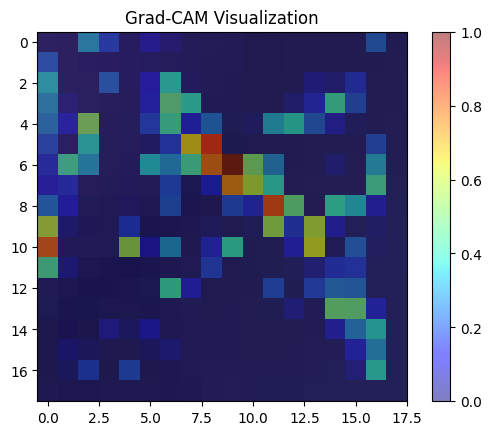

In [17]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvNet().to(device)
model.eval()

# Function to apply Grad-CAM
def apply_gradcam(model, input_img, target_layer, target_class):
    grad_cam = LayerGradCam(model, target_layer)
    attribution = grad_cam.attribute(input_img, target=target_class)
    attribution = attribution.squeeze().cpu().detach().numpy()

    # Normalize the attribution map
    attribution = np.maximum(attribution, 0)
    attribution = attribution / attribution.max()

    return attribution

target_layer = model.conv4
target_class = 0

# Visualize Grad-CAM
def visualize_gradcam(input_img, gradcam_result):
    input_img = input_img.squeeze().cpu().numpy().transpose(1, 2, 0)
    input_img = input_img - input_img.min()
    input_img = input_img / input_img.max()

    plt.imshow(input_img)
    plt.imshow(gradcam_result, cmap='jet', alpha=0.5)
    plt.colorbar()
    plt.title("Grad-CAM Visualization")
    plt.show()

input_img = image_tensor
target_class = 0

gradcam_result = apply_gradcam(model, input_img, target_layer, target_class)

visualize_gradcam(input_img, gradcam_result)


#### Explanation of the Grad-CAM Result:
Here we see the heat map of the regions of the input image that contributed to the model's decision. The regions in dark blue played a lesser role than the ones with orange and red. On comparing with the same input image, we see that the regions around the cat's face has played a more important role in the model's decision than other regions. This also aligned with the result obtained from Integrated Gradients.


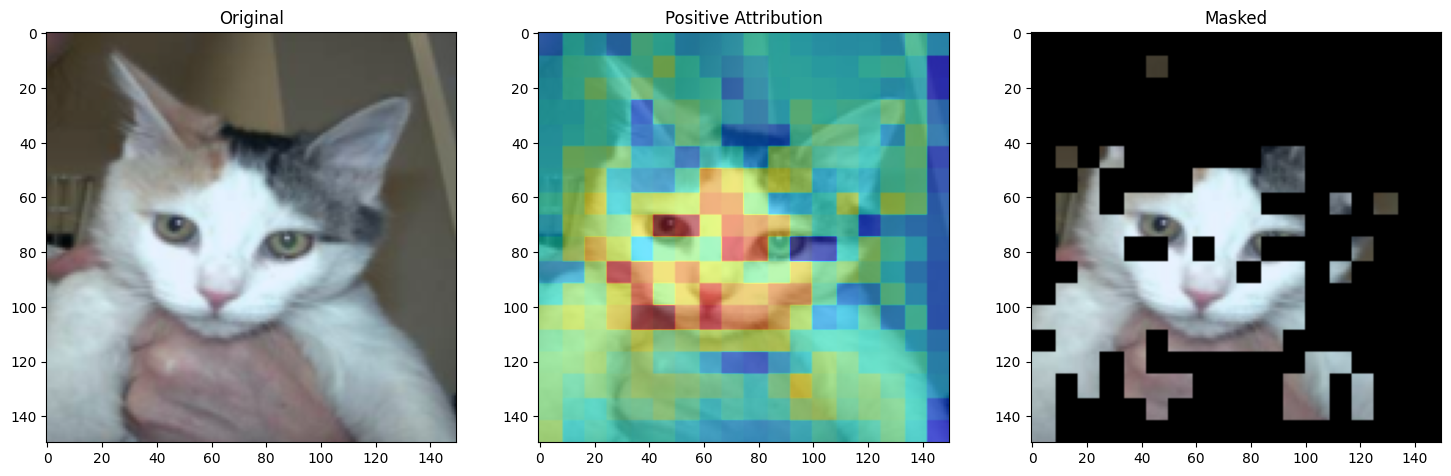

In [18]:
# Upsampling and viewing the positive attribute and masked image

model.eval()

# Function to apply Grad-CAM
def apply_gradcam_and_upsample(model, input_img, target_layer, target_class):
    grad_cam = LayerGradCam(model, target_layer)
    attribution = grad_cam.attribute(input_img, target=target_class)

    upsample_attr = LayerAttribution.interpolate(attribution, input_img.shape[2:])
    upsample_attr = upsample_attr.squeeze().cpu().detach().numpy()
    upsample_attr = np.maximum(upsample_attr, 0)
    upsample_attr = upsample_attr / upsample_attr.max()

    return upsample_attr

target_layer = model.conv4

# Visualize the original image, Grad-CAM heatmap, and masked image
def visualize_multiple(input_img, gradcam_result):
    input_img = input_img.squeeze().cpu().numpy().transpose(1, 2, 0)
    input_img = input_img - input_img.min()
    input_img = input_img / input_img.max()

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    ax[0].imshow(input_img)
    ax[0].set_title("Original")

    ax[1].imshow(input_img)
    ax[1].imshow(gradcam_result, cmap='jet', alpha=0.5)
    ax[1].set_title("Positive Attribution")

    mask = np.where(gradcam_result > 0.5, 1, 0)
    masked_image = input_img * mask[:, :, np.newaxis]
    ax[2].imshow(masked_image)
    ax[2].set_title("Masked")

    plt.show()

input_img = image_tensor
target_class = 0

gradcam_result = apply_gradcam_and_upsample(model, input_img, target_layer, target_class)
visualize_multiple(input_img, gradcam_result)


#### Explanation of the Result:-

Grad-CAM is again implemented, and the heat map is upscaled to the dimensions of the input image. The first image shows the input image. The second one overlays the attribution heatmap which was upscaled to the size of the input image. The third image shows only the important or significant regions of the image and masks the other regions. We can see, from images 2 and 3, that the important regions for the model's decision making process are the regions around the face.